In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50 ,DenseNet121, EfficientNetB7,VGG16 ,VGG19
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import ModelCheckpoint , ReduceLROnPlateau , EarlyStopping

In [2]:
# Load the dataset
df = pd.read_csv('sufffle_image.csv')
df["category"] = df["category"].replace({0: 'Normal', 1: 'COVID-19', 2: 'Viral Pneumonia'})

In [3]:
# Divide the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)
validate_df,test_df = train_test_split(val_df, test_size=0.50, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [4]:
# Set your IMAGE_SIZE and other parameters
IMAGE_SIZE = (180,180)
batch_size = 16

In [5]:
#Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
      batch_size=batch_size
)
   

Found 27120 validated image filenames belonging to 3 classes.
Found 3390 validated image filenames belonging to 3 classes.


In [6]:
# Build DenseNet-121 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

In [7]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [8]:
for layer in base_model.layers[:-2]:
    layer.trainable = False

In [9]:
# Adding my custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

In [10]:
# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

                                                                 
 block4_conv2 (Conv2D)       (None, 22, 22, 512)       2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 22, 22, 512)       2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 11, 11, 512)       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 11, 11, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 11, 11, 512)       2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 11, 11, 512)       2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 5, 5, 512)         0         
                                                                 
 global_av

c:\Users\Iftek\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.000001)
earlystop = EarlyStopping(
    monitor='val_loss',  # You can change this to another metric like 'val_accuracy'
    patience=10,  # Wait for 10 epochs to see if overfitting is resolved
    restore_best_weights=True,
    verbose=1
)
callbacks = [earlystop, learning_rate_reduction]

In [13]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [14]:
epochs = 100

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)
model.save('transfer_VGG.h5')

C:\Users\Iftek\AppData\Local\Temp\ipykernel_16840\4127188724.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
1695/1695 [==============================] - 282s 162ms/step - loss: 0.3532 - accuracy: 0.8629 - val_loss: 0.3722 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 2/100
1695/1695 [==============================] - 295s 174ms/step - loss: 0.2517 - accuracy: 0.9050 - val_loss: 0.2135 - val_accuracy: 0.9206 - lr: 0.0010
Epoch 3/100
1695/1695 [==============================] - 301s 177ms/step - loss: 0.2218 - accuracy: 0.9183 - val_loss: 0.3355 - val_accuracy: 0.8809 - lr: 0.0010
Epoch 4/100
1695/1695 [==============================] - 298s 176ms/step - loss: 0.1949 - accuracy: 0.9282 - val_loss: 3.2070 - val_accuracy: 0.5803 - lr: 0.0010
Epoch 5/100
1695/1695 [==============================] - 295s 174ms/step - loss: 0.1917 - accuracy: 0.9304 - val_loss: 0.2625 - val_accuracy: 0.9052 - lr: 0.0010
Epoch 6/100
1695/1695 [==============================] - 294s 173ms/step - loss: 0.1752 - accuracy: 0.9369 - val_loss: 0.3475 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 7/100
1695/1695 [=====

In [15]:
actual_epochs = len(history.history['loss'])

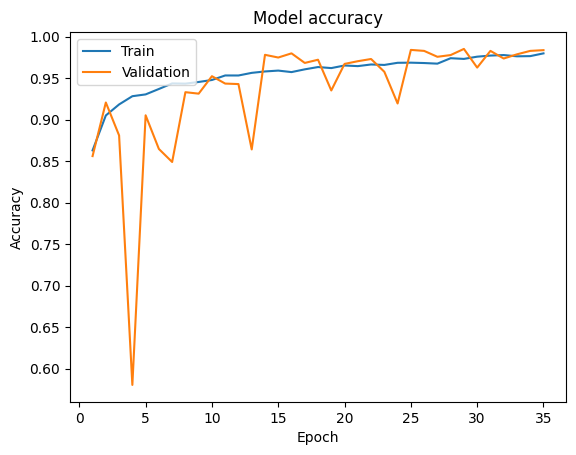

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
numEpochs = range(1,  actual_epochs + 1)
plt.plot(numEpochs,history.history['accuracy'])
plt.plot(numEpochs,history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

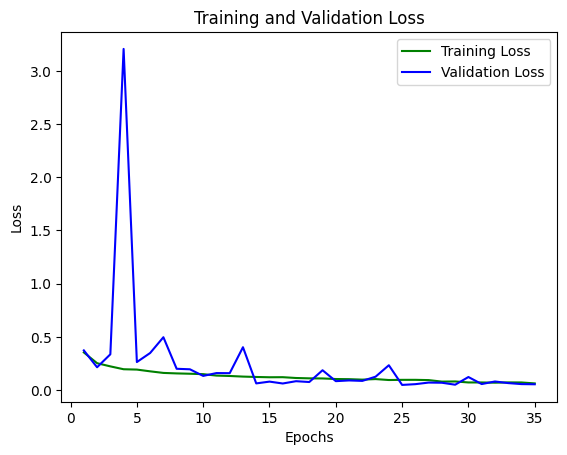

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  actual_epochs + 1)
plt.plot( numEpochs,loss, 'g', label='Training Loss')
plt.plot(numEpochs,val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,filename,category
0,HE\Pneumonia\Viral Pneumonia\images\HE-person1...,Viral Pneumonia
1,Datasets\COVID-19_Radiography_Dataset\COVID\im...,COVID-19
2,CL+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
3,Datasets\COVID-19_Radiography_Dataset\COVID\im...,COVID-19
4,HE\Pneumonia\Viral Pneumonia\images\HE-person1...,Viral Pneumonia
...,...,...
3386,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal
3387,HE\Pneumonia\Viral Pneumonia\images\HE-person6...,Viral Pneumonia
3388,CL+MEDIAN\COVID-19_Radiography_Dataset\Viral P...,Viral Pneumonia
3389,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal


In [19]:
nb_samples = test_df.shape[0]

In [20]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(    
    test_df, 
    directory=None,
    x_col='filename',
    y_col='category',
    target_size = IMAGE_SIZE,
    
    class_mode='categorical',
    batch_size = batch_size,
    shuffle = False,
)

Found 3391 validated image filenames belonging to 3 classes.


In [21]:
import numpy as np

In [22]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))
predict

C:\Users\Iftek\AppData\Local\Temp\ipykernel_16840\1469141313.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))


array([[7.2208328e-05, 1.3426445e-01, 8.6566329e-01],
       [9.9877661e-01, 8.4077183e-04, 3.8259148e-04],
       [9.9845874e-01, 1.0908316e-03, 4.5040404e-04],
       ...,
       [2.0443542e-07, 3.1890879e-06, 9.9999666e-01],
       [1.3245823e-04, 9.9978727e-01, 8.0382670e-05],
       [9.9999201e-01, 1.9553606e-06, 6.0709426e-06]], dtype=float32)

In [23]:
test_df['predict_category'] = np.argmax(predict, axis=-1)

In [24]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['predict_category'] = test_df['predict_category'].replace(label_map)

In [25]:
test_df['predict_category'] = test_df['predict_category'].replace({'Normal': 0, 'COVID-19': 1, 'Viral Pneumonia': 2})

In [26]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['predict_category']
    
    # img = load_img(filename, target_size=IMAGE_SIZE)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    # print(third_phrase)

    if 'Normal' in third_phrase:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID' in third_phrase:
        
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in third_phrase:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
    

In [27]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 97.70%
Correct Predictions: 3313 Total Predictions: 3391

Normal Predictions: 1131 Accuracy 97.16%
COVID-19 Predictions: 1056 Accuracy 97.51%
Viral Pneumonia Predictions: 1126 Accuracy 98.43%


In [28]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    # print(filename)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    if 'Normal' in third_phrase: actual.append(0)
    if 'COVID' in third_phrase: actual.append(1)
    if 'Viral Pneumonia' in third_phrase: actual.append(2)
    # print(f'Actual :{row[1][1]}')   
    # print(f'prediction :{row[1][2]}')   
    pred.append(row[1][2])

C:\Users\Iftek\AppData\Local\Temp\ipykernel_16840\4069215994.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filename = row[1][0]
C:\Users\Iftek\AppData\Local\Temp\ipykernel_16840\4069215994.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(row[1][2])


In [29]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [30]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1164
           1       0.98      0.98      0.98      1083
           2       0.99      0.98      0.99      1144

    accuracy                           0.98      3391
   macro avg       0.98      0.98      0.98      3391
weighted avg       0.98      0.98      0.98      3391



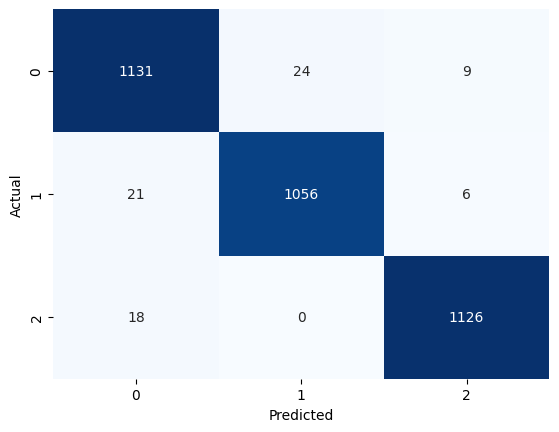

In [31]:
conf_matrix = confusion_matrix(actual, pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

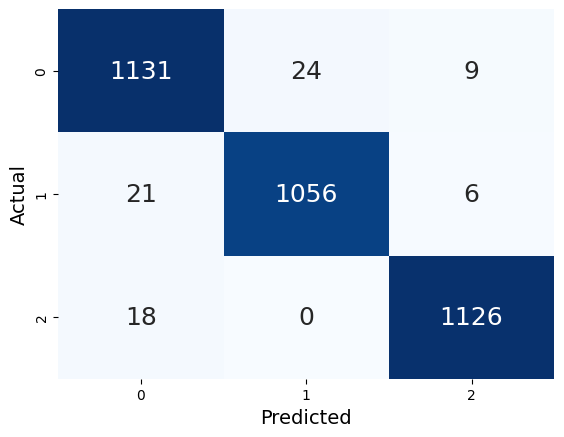

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = [[1131, 24, 9], [21, 1056, 6], [18, 0, 1126]]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 18})
plt.xlabel('Predicted', fontsize=14)  # Adjust the font size as needed
plt.ylabel('Actual', fontsize=14)  # Adjust the font size as needed
plt.savefig('vgg19.pdf')
plt.show()